# CASE STUDY - Evaluation Metrics and Business Metrics


The hype surrounding the combination of good data with state-of-the art machine learning can fall short of expectations.  There are many reasons for this, far too numerous to discuss here, but there are some commonalities and trends.  See the white paper [Beyond the hype: A guide to understanding and successfully implementing artificial intelligence within your business](https://www.ibm.com/downloads/cas/8ZDXNKQ4) for a deeper dive into this.  This case study will focus on something that is referred to as the *follow-through*.  

The basic idea of the follow-through is to tune, train and deploy your model, then once you have collected some performance data return to the familiar world of data visualization and hypothesis testing to investigate the relationship between model performance (evaluation metrics) and business metrics.

One of the reasons there has not been much focus on follow-through is that there are many projects and time is always precious.  The model is in production---okay what is the next project?  For this reason we propose readying your code for that post-performance investigation *before* the model is deployed. We are going to take it a step further and simulate performance data.  This simulation function will emulate a real-world scenario and provide a tool that one could use in their own projects to ensure that the code is ready to accommodate follow-through.

In [1]:
# Don't use during development
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
import time
import re
import itertools
from string import punctuation, printable
import numpy as np
import pandas as pd
import spacy
from spacy.lang.en import English
import joblib
from collections import Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import seaborn as sns

In [3]:
from spacy.lang.en import English

In [4]:
plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## Synopsis


AAVAIL has recently enabled comments on its streaming service.  There are a number of data science projects that have 
become a priority since.  The text will soon need to be monitored for automatic removal of inappropriate content.  Users and posts will need to be flagged for human review.  Your project will be to leverage comments for customer retention.  Following best practices you are being asked now to build your code base to ensure you are ready when the first week of comments are ready.  Management has made the specific ask that they want you to monitor the relationship between your model's performance and a customer retention business metric.  

As a first pass we are going to perform text classification for customer retention so the movie comments data set with sentiment as a target is a perfect data set to start building a code base. Once we have iterated with respect to transforms and models we will pass the model pipeline to a special function that will simulate model performance **and**  business performance for six months.  Finally we will create a visualization to help investigate and monitor the relationship between the two.

## Outline


1. Optimize a text classification Pipeline to be deployed for use
2. Iterate on and tune the model pipeline
3. Use visualization techniques to relate the evaluation metrics to the business metrics


## Data

Here we see how to load the data.  These are the same data that were used for the topic modeling case study. 

* [download the movie review data](http://www.nltk.org/nltk_data)
* the ``target`` here is sentiment grouped into positive and negative categories.  You will use this data set to prepare a code base that will ensure you can quickly refine a customer retention model once enough video translation comments are collected by AAVAIL.

In [5]:
data_dir = os.path.join("data")
movie_reviews = load_files(os.path.join(data_dir,"movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names

### TASK 1

Use print statements and visualization to summarize the data

---------------------------
num docs 2000
median tokens 698.0
num tokens 1496584
unique tokens 57588
---------------------------


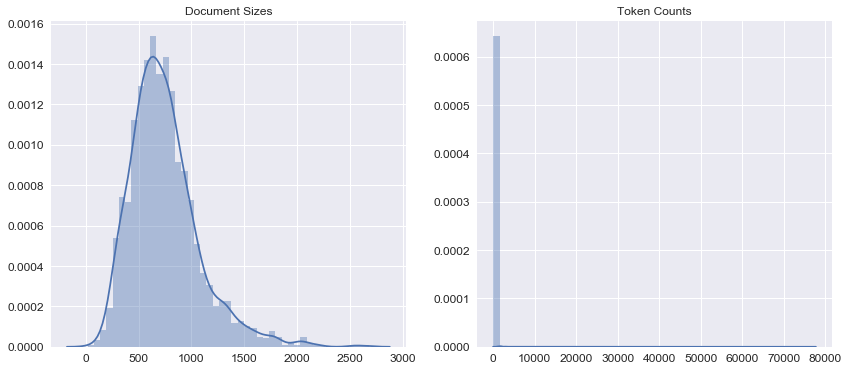

In [6]:
def plot_corpus_summary(corpus):
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    tokens_per_doc = [len(str(doc).split(" ")) for doc in corpus]
    all_docs = [str(doc).split(" ") for doc in corpus]
    all_docs = list(itertools.chain.from_iterable(all_docs))
    unique_tokens, token_counts = np.unique(all_docs, return_counts=True)
    
    print("---------------------------")
    print("num docs", len(corpus))
    print("median tokens",np.median(tokens_per_doc))
    print("num tokens",len(all_docs))
    print("unique tokens", unique_tokens.size)
    print("---------------------------")
  
    sns.distplot(tokens_per_doc, ax=ax1)
    sns.distplot(token_counts, ax=ax2)
    ax1.set_title("Document Sizes")
    ax2.set_title("Token Counts") 
    
plot_corpus_summary(X)

### TASK 2

Process the data.  There are many options to consider when you process the tokens from a corpus of text.  These are some of the questions you might want to ask:

* Which stop words do I include?
* Which stemmer/lemmatizer is best?
* Which n-grams do I include?
* Do I filter based on frequency min an max?

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via stemming or lemmatization.  The next code block provides a lemmatization function that makes use of the library spacy.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

Use the following function to process the data into into a clean corpus.

In [7]:
nlp = spacy.load('en')

In [8]:
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub("\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)   
    
## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

pron fool people time people time pron fool people time abraham lincoln

pron can fool some of the people all of the time and all of the people some of the time but pron can not fool all of the people all of the time abraham lincoln


In [9]:
saved_corpus = 'processed-corpus.npz'
if not os.path.exists(saved_corpus):
    time_start = time.time()
    processed_corpus = [lemmatize_document(doc, STOPLIST) for doc in X]
    args = {'corpus':processed_corpus}
    np.savez_compressed(saved_corpus,**args)
    print("process time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print("loading {} from file".format(saved_corpus))
    npz = np.load(saved_corpus)
    processed_corpus = npz['corpus']

loading processed-corpus.npz from file


### TASK 3

Summarize the processed corpus again.

---------------------------
num docs 2000
median tokens 336.0
num tokens 716351
unique tokens 44193
---------------------------


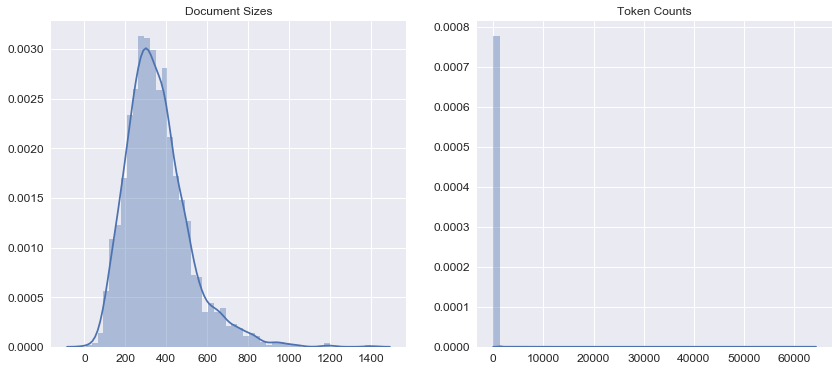

In [10]:
plot_corpus_summary(processed_corpus)

### TASK 4

* Create a train/test split and a transformation pipeline connected to a base model.  

A bag-of-words model is a representation of text.  A document or sentence is represented as numeric counts of the individual words, without considering grammar and punctuation.  Even the word order is ignored unless you expand your feature matrix with n-grams.  
We can calculate various measures to characterize the text. The most common type of matrix derived from the bag-of-words
representation is the **term frequency (TF)**, which is the number of times a token appears in the text.  Another useful matrix is the term frequency-inverse document frequency (tf-idf) matrix. There are variations on tf-idf and in general these derived matrices can be thought of as *transforms* that can be optimized in an iterative fashion.
   
* Finish the pipeline with a naive Bayes classifier to compare transforms.  

Naive Bayes approaches are a commonly used base model for text classification.

There are several types of Naive Bayes model.  
* Gaussian: It is used in classification and it assumes that features follow a normal distribution.
* Multinomial: It is used for discrete counts.
* Bernoulli: The binomial model is useful if your feature vectors are binary (i.e. zeros and ones).
* Complement: CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets

In [11]:
rs = 42
X_train, X_test, y_train, y_test = train_test_split(processed_corpus, y, test_size=0.25, stratify=y, random_state=rs)
print("---------------------------")
print("train", sorted(Counter(y_train).items()))
print("test", sorted(Counter(y_test).items()))
print("targets", target_names)
print("---------------------------")

---------------------------
train [(0, 750), (1, 750)]
test [(0, 250), (1, 250)]
targets ['neg', 'pos']
---------------------------


In [12]:
from sklearn.naive_bayes import ComplementNB

time_start = time.time()
pipe1  = Pipeline(steps=[('tfidf',TfidfVectorizer()),
                         ('nb', ComplementNB())])

param_grid1 = {
    'tfidf__max_df':[0.4,0.6,0.8],
    'tfidf__max_features': [2000,4000,6000],
    'nb__alpha':[0.01, 0.1, 1.0]   
}

grid1 = GridSearchCV(pipe1, param_grid=param_grid1, cv=5, n_jobs=-1)
grid1.fit(X_train, y_train)
y_pred = grid1.predict(X_test)
print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
print(classification_report(y_test, y_pred, target_names=target_names))
print(grid1.best_params_)

train time 00:01:36
              precision    recall  f1-score   support

         neg       0.79      0.82      0.81       250
         pos       0.82      0.78      0.80       250

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500

{'nb__alpha': 1.0, 'tfidf__max_df': 0.6, 'tfidf__max_features': 6000}


### TASK 5

Let's see if we can beat the base model.

In [13]:
from sklearn.linear_model import SGDClassifier

time_start = time.time()
pipe2  = Pipeline(steps=[('tfidf',TfidfVectorizer()),
                         ('sgd', SGDClassifier())])

param_grid2 = {
    'tfidf__max_df':[0.4,0.6,0.8],
    'tfidf__max_features': [2000,4000,6000],
    'sgd__penalty':['l2', 'l1', 'elasticnet']
}

grid2 = GridSearchCV(pipe2, param_grid=param_grid2, cv=5, n_jobs=-1)
grid2.fit(X_train, y_train)
y_pred = grid2.predict(X_test)
print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
print(classification_report(y_test, y_pred, target_names=target_names))
print(grid2.best_params_)

train time 00:01:40
              precision    recall  f1-score   support

         neg       0.81      0.80      0.80       250
         pos       0.80      0.82      0.81       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500

{'sgd__penalty': 'l2', 'tfidf__max_df': 0.6, 'tfidf__max_features': 6000}


### TASK 6

Now that we have a decent classifier here is a function that will to simulate the results obtained from the deployed model over time. Simply enter the `accuracy` value. Obtained from `classification_report` on the test data.

A data frame will be returned containing:

1. Week number
2. The number of churned subscribers per 100 (expressed as a decimal)
3. The accuracy score
4. AAVAIL Website version id

Use the determined test accuracy to get back simulated data.  Then, with EDA, investigate the relationship between the evaluation metric and the business metric.  At a minimum the investigation should involve visualization, but hypothesis testing and/or statistical models could be useful here.

In [14]:
def simulate_production(test_accuracy, num_weeks=26):
    """
    INPUT: takes a value for test model accuracy
    OUTPUT: returns a data frame with relevant metrics
    """
    
    if test_accuracy < 0 or test_accuracy > 1.0:
        raise Exception("test accuracy must be between 0 and 1")
    
    ## simulate test accuracy (two component gaussian)
    modes = np.random.binomial(n=1,p=0.3,size=num_weeks)
    mode1 = np.where(modes==0)[0]
    mode2 = np.where(modes==1)[0]
    projected_em = np.zeros(num_weeks)
    projected_em[mode1] = stats.norm(loc=test_accuracy,scale=0.02).rvs(mode1.size)
    projected_em[mode2] = stats.norm(loc=test_accuracy,scale=0.04).rvs(mode2.size)
    projected_em[projected_em > 0.99] = 0.99
    
    #print(projected_em)
    min_val = 0.5
    projected_bm = (1.0 - ((projected_em - min_val) / (1.0 - min_val))) * .1
    #print(projected_bm)
    
    website_effects = np.array([0.0,0.02,-0.02])
    website = np.sort(np.random.randint(0,3,num_weeks))
    
    for sv in np.unique(website):
        projected_bm[website==sv] = projected_bm[website==sv] + website_effects[sv]
    
    data = {'churn_rate':projected_bm,
            'accuracy':projected_em,
            'website':website}
    
    return(pd.DataFrame(data))

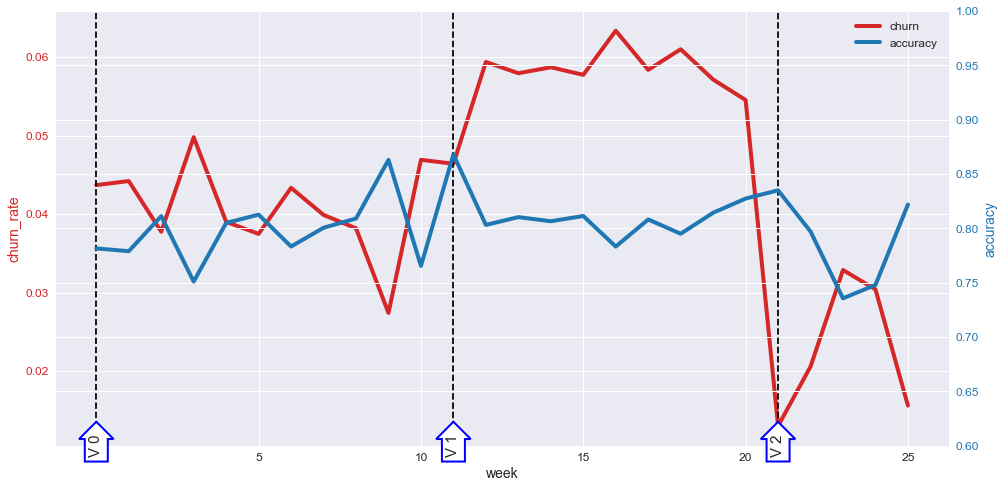

In [15]:
report = classification_report(y_test, y_pred, target_names=target_names,output_dict=True)
df = simulate_production(report['accuracy'])

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

n_weeks = df.shape[0]

color = 'tab:red'
ax1.set_xlabel('week')
ax1.set_ylabel('churn_rate', color=color)
p1 = ax1.plot(np.arange(n_weeks), df['churn_rate'], color=color, lw=4)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
p2 = ax2.plot(np.arange(n_weeks), df['accuracy'], color=color, lw=4)
ax2.tick_params(axis='y',labelcolor=color)
ax2.set_ylim((0.6,1.0))

ax2.legend([p1[0],p2[0]],["churn","accuracy"])

bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="b", lw=2)

last = -1
for i,v in enumerate(df['website'].values):
    if v != last:
        ax2.text(i, 0.6, "V {}".format(v), ha="center", va="center", 
                 size=15,rotation=90,
                 bbox=bbox_props)
        ax2.vlines(i,0.6,1.0,linestyles='--')
    last=v

## Comments

We can see that the version 1 of the website seems to increase churn, while version 2 decreases it.  Increasing accuracy is otherwise related to decreasing churn_rate. If we wanted to take this a step further we could use a simple GLM.

In [16]:
import statsmodels.formula.api as smf

mod = smf.ols(formula='churn_rate ~ accuracy + C(website)', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             churn_rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.608e+29
Date:                Mon, 17 Feb 2020   Prob (F-statistic):          7.40e-318
Time:                        09:44:16   Log-Likelihood:                 938.70
No. Observations:                  26   AIC:                            -1869.
Df Residuals:                      22   BIC:                            -1864.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2000   3.01e-16   6.

Looking at the `simulate_production` function we can see that the sources of variation in the model are a product of the two features, which explains the good model fit. 

Going through the exercise of creating a plot like this before the model is deployed and in production is a clear and effective way to communicate to business stakeholders exactly the type of data needed for an investigation into the business impact.

<iframe src="https://player.vimeo.com/video/87110435" width="640" height="360"  frameborder="0" allowfullscreen></iframe>